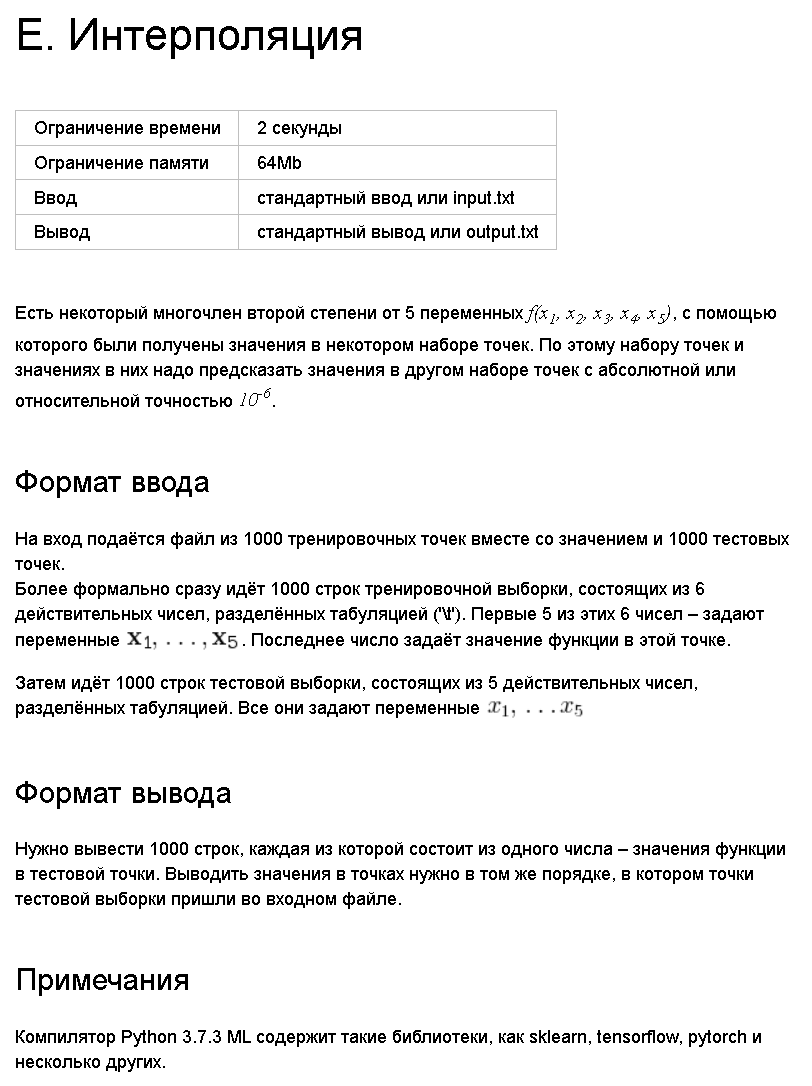

In [11]:
# Сгенирируем тренировачные и тестовые данные
import random
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy

from tqdm.autonotebook import tqdm

np.random.seed(42)

# Сгенирируем тренировачные и тестовые данные по 1_000
with open('interpolation_input.txt', 'w', encoding='utf-8') as output_file:
    # Некоторый многочлен второй степени от 5 переменных
    def func(x1, x2, x3, x4, x5):
        y = (x1**2 + x2*x3*x4*x5 + 1)
        print(x1, x2, x3, x4, x5, y, sep='\t', file=output_file)

    for _ in range(2_000):
        func(*np.random.uniform(0, 100, size=5))

In [2]:
# Считаем тестовые и тринировачные данные
with open('interpolation_input.txt') as input_file:
    arr = np.array([line.strip().split() for line in input_file.readlines()], dtype=float)

X_train, y_train = arr[:800, :5], arr[:800, 5:].ravel()
X_val, y_val = arr[800:1_000, :5], arr[800:1_000, 5:].ravel()
X_test, y_test = arr[1_000:, :5], arr[1_000:, 5:].ravel()

In [3]:
# Преобразовать данные в Tensor
X_train = torch.from_numpy(X_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
X_val = torch.from_numpy(X_val).to(torch.float32)
y_val = torch.from_numpy(y_val).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).to(torch.float32)

In [4]:
# Подготовка данных к обучению

BATCH = 64 # Сколько данных грузится в модель за раз

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Похоже на итератор через next пуляет данными для 2 тензоров по размкру BATCH
# next(iter(train_loader))
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

In [5]:
# Подготовим устройство
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Линейная модель в pyTorch
class MyLinearRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Инициализация весов и создание слоя
        self.W = nn.Parameter(torch.randn((in_features, out_features),
                                          requires_grad=True))
        # Инициализация баеса
        self.b = nn.Parameter(torch.ones((out_features),
                                          requires_grad=True))
    
    # Прямое прохождение данных через модель
    # Формирует динамический граф вычисления
    # Граф будет создаваться в момент вычисления
    def forward(self, x):
        # Признаки умножаем на наши веса
        x = x @ self.W
        # Прибавим баес
        x += self.b
        return x



In [15]:
# Обучение

# Подготовка
# 1. Задать модель nn.Module
model = MyLinearRegression(5, 1)
# 2. Задать функцию потерь - nn.NAME_OF_FUNC
loss_function = nn.BCEWithLogitsLoss
# 3. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
optimizer = torch.optim.SGD(model.parameters(), lr=.042)

# Поместить модель и метрику на GPU
model = model.to(device)
r2score = R2Score().to(device)

# Создать вспомогательные списки для данных
# Loss на каждой итерации т.е. на каждом batch
losses_train = []
# Общий loss
total_loss = []
# Метрики
r2_val = []

# Задать кол-во эпох
MAX_EPOCHS = 100

# Для каждй эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
    # для каждой части датасета batch
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        # ЭТАП ОБУЧЕНИЯ
        # Мы переводим модель в режим обучения
        model.train()
        # Обнуляем градиенты у оптимизатора c предыдущего batch
        optimizer.zero_grad()
        # Пропускаем данные через модель
        # В этот момент сработает метод forward у модели
        # Формируется граф
        outputs = model(X_batch.to(device))
        # Выравниваем выходы в одномерный тензор
        outputs = outputs.view(-1)
        # Считаем loss
        loss = loss_function(outputs, y_batch.to(device))
        # делаем шаг в обратном направлении. Обратное распространение ошибки
        loss.backward()
        # Собираем losses
        # Отцепляем его от tensor, переводим на cpu, переводем numpy, получаем число скаляр.
        losses_train.append(loss.detach().cpu().numpy().item())
        # Делаем шаг оптимизатора на основе данных которые получили
        optimizer.step()
    # Собираем средний loss
    total_loss.append(np.mean(losses_train))
    # ШАГ ВАЛИДАЦИИ
    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        # режим инференса или валидации, тестирования
        # Отключать слои и неоткидывать их если в dropout
        model.eval()
        # Без градиентов
        with torch.no_grad():
            # Считаем данные
            outputs = model(X_batch.to(device))
            outputs = outputs.view(-1)
            loss = loss_function(outputs, y_batch.to(device))
            # Считаем метрику
            batch_r2 = r2score(outputs, y_batch).to(device)
            r2_val.append(batch_r2.detach().cpu().numpy().item())

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [17]:
# Очистить GPU после высеслений
with torch.no_grad():
    torch.cuda.empty_cache()

In [18]:
# Полносвязная нейроная сеть

class NN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Пишем свои слои
        # Следим чтобы входило в слой столько сколько выходило из прежнего слой
        self.lin_linear_1 = nn.Linear(in_features, in_features * 4)
        self.lin_linear_2 = nn.Linear(in_features * 4, in_features * 2)
        self.lin_linear_3 = nn.Linear(in_features * 2, out_features)
        self.relu = F.relu

    def forward(self, x):
        # Указываем в каком порядке работать с слоями
        x = self.lin_linear_1(x)
        x = self.relu(x)            # все значения меньше 0 превратить в 0
        x = self.lin_linear_2(x)
        x = self.relu(x)
        x = self.lin_linear_3(x)
        return x

In [7]:
with open('output.txt', 'w', encoding='utf-8') as output_file:
    for pred in y_train_pred:
        print(pred, file=output_file)

NameError: name 'y_train_pred' is not defined

In [ ]:
abs(train[:, 5:].ravel() - y_train_pred)

array([6.39966513e+04, 2.56361913e+05, 1.60545426e+04, 5.60957688e+04,
       6.51786685e+04, 2.32799809e+04, 8.72965704e+05, 2.12667383e+05,
       2.14112907e+05, 6.10393966e+04, 4.95013893e+05, 9.17962357e+03,
       3.93021478e+04, 9.30588258e+03, 4.75768830e+05, 2.05695874e+04,
       1.05490055e+04, 3.77106291e+05, 2.48156153e+05, 4.58510701e+03,
       2.36507377e+05, 7.57972138e+03, 4.15705989e+05, 4.38437817e+05,
       1.18938530e+04, 8.62746229e+03, 1.09281124e+05, 1.32899131e+05,
       3.60712683e+04, 3.66814078e+03, 2.44446202e+05, 4.65644178e+04,
       3.10505825e+04, 8.36055676e+03, 3.75656243e+04, 1.23413036e+05,
       2.00505051e+05, 7.64594225e+04, 1.43768189e+05, 6.21069785e+05,
       4.93649349e+05, 5.84044236e+02, 4.30593947e+04, 3.61102918e+05,
       4.05209090e+04, 5.06333638e+05, 5.63215965e+04, 7.88929734e+04,
       1.93702102e+04, 8.04416452e+05, 2.09667242e+04, 4.09100374e+04,
       2.40575221e+05, 4.80465282e+04, 4.39647793e+05, 3.99491979e+05,
      